背景
研究问题是估计当消费者在预定酒店时，为其分配一间与之前预定过的房间不同的房间对消费者取消当前预定的影响。分析此类问题的金标准是「随机对照试验」（Randomized Controlled Trials），即每位消费者被随机分配到两类干预中的一类：为其分配与之前预定过的房间相同或不同的房间。

In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger("dowhy").setLevel(logging.INFO)

dataset = pd.read_csv('../../数据集/因果识别数据集/hotel_bookings.csv')
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [2]:
#preprocess the data
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [3]:
#drop parts of features
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True) 
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')

In [4]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [ ]:
#check if the target will diff when booking changes to make sure if it is a confounding variable
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
print(counts_sum/10000)

counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
print(counts_sum/10000)

In [6]:
import gc
gc.collect()

以上结果说明的确有影响，但是不能明确是哪个因子发挥的作用，假设以下因素都会产生影响，可作为混淆因子
market_segment 参数有两种取值：TA 指旅行者，TO 指旅游公司，该参数会影响 lead_time（即预约和到达之间的时间间隔）
country 参数会决定一个人是否会提早预订（即影响 lead_time ）以及其喜爱的食物（即影响 meal ）
lead_time 会影响预订的等待时间（ days_in_waiting_list ）
预订的等待时间 days_in_waiting_list、总停留时间 total_stay 以及客人数量 guests 会影响预订是否被取消
之前预订的取消情况 previous_bookings_not_canceled 会影响该顾客是否为 is_repeated_guest；这两个变量也会影响预订是否被取消
booking_changes 会影响顾客是否被分配到不同的房间，也会影响预订取消情况
除了 booking_changes 这一混杂因子外，一定还存在着其他混杂因子，同时影响干预和结果

In [5]:
#define the casual graph
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

D:\software\anaconda\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


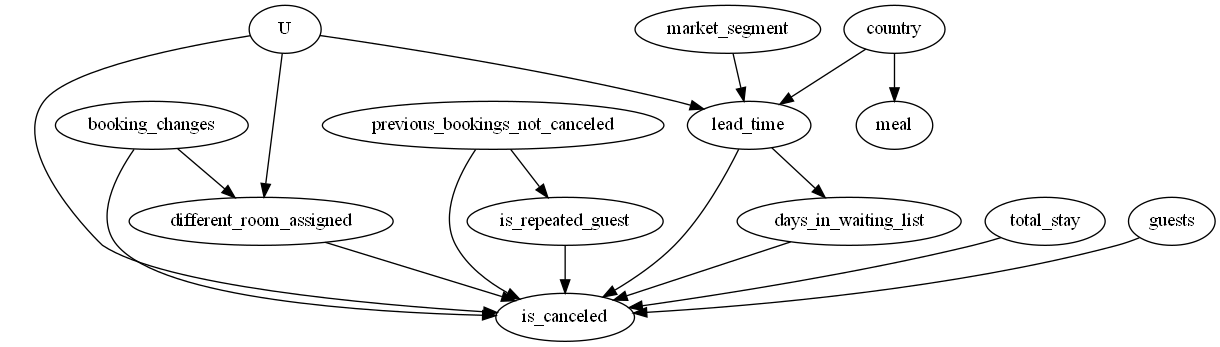

In [6]:
#and visliazate the graph
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
# model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|booking_changes,guests,is_repeated_gu
d[different_room_assigned]                                                    

                                                                              
est,total_stay,required_car_parking_spaces,total_of_special_requests,days_in_w
                                                                              

                             
aiting_list,lead_time,hotel])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,guests,is_repeated_guest,total_stay,required_car_parking_spaces,total_of_special_requests,days_in_waiting_list,lead_time,hotel,U) = P(is_canceled|different_room_assigned,bookin

In [24]:
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")

print(estimate)

D:\software\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\software\anaconda\lib\site-packages\dowhy\causal_estimators\propensity_score_estimator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.propensity_score_column] = self.propensity_score_model.predict_proba(
D:\software\anaconda\l

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|booking_changes,guests,lead_time,days
d[different_room_assigned]                                                    

                                                                              
_in_waiting_list,hotel,total_of_special_requests,is_repeated_guest,total_stay,
                                                                              

                             
required_car_parking_spaces])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,guests,lead_time,days_in_waiting_list,hotel,total_of_special_requests,is_repeated_guest,total_stay,required_car_parking_spaces,U

In [ ]:
#robust check
#Random Common Cause
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

In [ ]:
#Placebo Treatment Refuter
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

In [ ]:
#Data Subset Refuter
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

DoWhy可以做可视化、形式化和测试所做的假设，这样可以更好地理解分析结果并避免得出错误的结论。主要通过关注假设并尽可能引入对假设有效性的自动检查来实现。DoWhy的强大之处在于它提供了一个formal的因果框架来编码领域知识，并且它可以运行自动化检查任何估计器方法的因果估计的鲁棒性。

此外，随着数据的维度变高，我们需要能够处理已知混淆的专门方法。EconML实现了许多最先进的因果估计方法。这个包有一个用于所有技术的通用API，每种技术都作为一系列机器学习任务来实现，允许使用任何现有的机器学习软件来解决这些子任务，从而允许您使用熟悉的ML模型，而不是学习新的工具箱。EconML的强大之处在于，你可以实现因果推理的最新技术，就像运行线性回归或随机林一样简单。

DoWhy+EconML提供了一个最先进的端到端因果推理框架，包括最新的因果估计和自动鲁棒性评估，使回答假设问题变得更加容易。

In [8]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=2, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|booking_changes,guests,is_repeated_gu
d[different_room_assigned]                                                    

                                                                              
est,total_stay,required_car_parking_spaces,total_of_special_requests,days_in_w
                                                                              

                             
aiting_list,lead_time,hotel])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,guests,is_repeated_guest,total_stay,required_car_parking_spaces,total_of_special_requests,days_in_waiting_list,lead_time,hotel,U

此外, dowhy+econml可以更好的观测关键调节变量的作用，从而分析影响的异质性，并提出具体的细分样本+干预方案：

DoWhy 的作用：

- 建立因果模型（LinearDML）(DML: LinearDL, CausalForestDML)
- 识别影响效果（LinearDML.dowhy.fit(): Backdoor，Frontdoor，IV）
- 检验因果假设 - 稳健性检验（添加随机共同原因变量、安慰剂检验、随机删除部分样本）

EconML DML 估计器的作用：

- 考虑干预的变动
- 分析影响的异质性
- EconML CATE SingleTreeCateInterpreter -- 展示各个 features 的作用大
- EconML CATE SingleTreePolicyInterpreter -- 提出最优政策方案，即指出具体的细分样本+干预方案，以达到收益最大

In [12]:
import warnings
warnings.simplefilter('ignore')
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

## 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

## 
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
# so, we can assum the feature:is_repreated_guest is mediation parameter
Y = dataset['is_canceled'].values
T = dataset['different_room_assigned'].values
X = dataset['is_repeated_guest'].values


confounder_cols = ['hotel', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests']
W = dataset[confounder_cols].values

In [ ]:
## init EconML in Linear model
est = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

## use DoWhy to estimate
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=['is_canceled'], treatment_names=['different_room_assigned'], feature_names=['is_repeated_guest'],
               confounder_names=confounder_cols, inference="statsmodels")

## draw graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model() 

In [ ]:
## output
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

In [ ]:
#get test data
sub_data = dataset.sample(n=10000, random_state=1)
X_test = sub_data['is_repeated_guest']

# Get treatment effect and its confidence interval
te_pred = est_dw.effect(X_test).flatten()
te_pred_interval = est_dw.effect_interval(X_test)

In [ ]:
# Compare the estimate and the truth
truth_te_estimate = subdata['is_canceled']
plt.figure(figsize=(10, 6))

plt.plot(X_test.flatten(), te_pred, label="Prediction Value")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Value")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Value Range",
)
plt.xlabel("is_repeated_guest")
plt.ylabel("is_cancelled")
plt.title("is_cancelled vs is_repeated_guest")
plt.legend(loc="lower right")

In [ ]:
## init EconML in CausalForest model
est = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

## use DoWhy to estimate
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=['is_canceled'], treatment_names=['different_room_assigned'], feature_names=['is_repeated_guest'],
               confounder_names=confounder_cols, inference="statsmodels")


## 计算干预效应及其置信区间
te_pred = est_nonparam_dw.effect(X_test).flatten()
te_pred_interval = est_nonparam_dw.effect_interval(X_test)

## 比较非参估计的结果和真实结果
plt.figure(figsize=(16, 10))
plt.plot(X_test.flatten(), te_pred, label="Prediction Value")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Value")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Value Range",
)
plt.xlabel("is_repeated_guest")
plt.ylabel("is_cancelled")
plt.title("is_cancelled vs is_repeated_guest")
plt.legend(loc="lower right")

In [ ]:
#Robust check
res_random = est_nonparam_dw.refute_estimate(method_name="random_common_cause")
print(res_random)

In [ ]:
res_unobserved = est_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

In [ ]:
res_placebo = est_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

In [ ]:
res_subset = est_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

In [ ]:
# Understand Treatment Effects with EconML
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_nonparam_dw, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=["is_repeated_guest"], fontsize=12)

In [ ]:
# Make Policy Decision with EconML
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est_nonparam_dw, X_test, sample_treatment_costs=-1)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=["is_repeated_guest"], treatment_names=["Repeated", "No-Repeated"], fontsize=12)